# Complete experiment to try to estimate the profits from a customer, in the next 10 days, given different offer choices to be shown.

Table of contents <a id='top'>

1. [Get the data and show it](#data)
2. [Create the Model](#model)
3. [Evaluate the Model](#eval)
4. [Analysis and Conclusions](#conclusions)
5. [Test Results](#test)

In [49]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error as mse

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.data.profit_10_days_dataset as p10
import src.visualization.visualize as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Get the data and show it <a id='data'/>
[Top](#top)

In [2]:
# Get the data
X_train, X_test, y_train, y_test, encoder, view_cols, profit_cols =\
p10.get_profit_10_days_data(fill_null=True, 
                        target=['viewed', 'profit_10_days'], drop_offer_id=False)

# Create the null offer
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)
%time _, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)
null_offer = pd.Series([0, 0, 'no_offer', 'no_offer', 0, 0, 0, 0, 0],
                               index=portfolio.columns,
                               name=portfolio.shape[0]).sort_index()

CPU times: user 2.61 s, sys: 244 ms, total: 2.85 s
Wall time: 1.86 s


In [3]:
print(X_train.shape)
print(y_train.shape)
X_train.head()

(25319, 130)
(25319, 2)


,offer_id,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,channel_mobile_success_ratio,difficulty_viewcol,duration_viewcol,reward_t_viewcol,channel_web_viewcol,channel_mobile_viewcol,channel_email_viewcol,channel_social_viewcol,offer_id_viewcol,offer_type_viewcol
0,5a8bc65990b245e5a138643cd4eb9837,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,...,0.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,5a8bc65990b245e5a138643cd4eb9837,informational
5,f19421c1d4aa40978ebb69ca19b0e20d,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,...,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
7,3f207df678b143eea3cee63160fa8bed,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,1.0,0.0,3f207df678b143eea3cee63160fa8bed,informational
8,2298d6c36e964ae4a3e7e9706d1fb8c2,40.0,O,57000.0,0,17540,7.0,7.0,discount,3.0,...,0.0,7.0,7.0,3.0,1.0,1.0,1.0,1.0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount
12,fafdcd668e3743c1bb461111dcafc2a4,59.0,F,90000.0,0,16864,10.0,10.0,discount,2.0,...,0.0,10.0,10.0,2.0,1.0,1.0,1.0,1.0,fafdcd668e3743c1bb461111dcafc2a4,discount


In [4]:
print(X_test.shape)
print(y_test.shape)
X_test.head()

(12778, 130)
(12778, 2)


,offer_id,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,channel_mobile_success_ratio,difficulty_viewcol,duration_viewcol,reward_t_viewcol,channel_web_viewcol,channel_mobile_viewcol,channel_email_viewcol,channel_social_viewcol,offer_id_viewcol,offer_type_viewcol
2,no_offer,33.0,M,72000.0,0,17277,0.0,0.0,no_offer,0.0,...,0.000000,5.0,5.0,5.0,1.0,1.0,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
10,0b1e1539f2cc45b7b9fa7c272da2e1d7,40.0,O,57000.0,0,17540,20.0,10.0,discount,5.0,...,0.333332,20.0,10.0,5.0,1.0,0.0,1.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
15,4d5c57ea9a6940dd891ad53e9dbe8da0,59.0,F,90000.0,0,16864,10.0,5.0,bogo,10.0,...,0.666664,10.0,5.0,10.0,1.0,1.0,1.0,1.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo
19,5a8bc65990b245e5a138643cd4eb9837,24.0,F,60000.0,0,17116,0.0,3.0,informational,0.0,...,0.999995,0.0,3.0,0.0,0.0,1.0,1.0,1.0,5a8bc65990b245e5a138643cd4eb9837,informational
24,fafdcd668e3743c1bb461111dcafc2a4,26.0,F,73000.0,0,17338,10.0,10.0,discount,2.0,...,0.333332,10.0,10.0,2.0,1.0,1.0,1.0,1.0,fafdcd668e3743c1bb461111dcafc2a4,discount


## 2. Create the model <a id='model'/>
[Top](#top)

In [5]:
model = p10.ProfitsPredictor(encoder=encoder, view_cols=view_cols, profit_cols=profit_cols)

## 3. Evaluate the model <a id='eval'/>
[Top](#top)

Due to the small amount of time instances, there will be no validation set, or grid search. Instead one model will be fitted and tested (a test set is separated).

In [6]:
%time model.fit(X_train, y_train)

CPU times: user 1min 50s, sys: 1.68 s, total: 1min 52s
Wall time: 1min 54s


ProfitsPredictor(encoder=BasicEncoderProfits(custom_features=None),
         profit_cols=['difficulty', 'duration', 'reward_t', 'channel_web', 'channel_mobile', 'channel_email', 'channel_social', 'offer_id', 'offer_type'],
         view_cols=['difficulty_viewcol', 'duration_viewcol', 'reward_t_viewcol', 'channel_web_viewcol', 'channel_mobile_viewcol', 'channel_email_viewcol', 'channel_social_viewcol', 'offer_id_viewcol', 'offer_type_viewcol'])

## 4. Analysis and Conclusions <a id='conclusions'/>
[Top](#top)

In [7]:
from xgboost import plot_importance

In [8]:
n_feats = 20

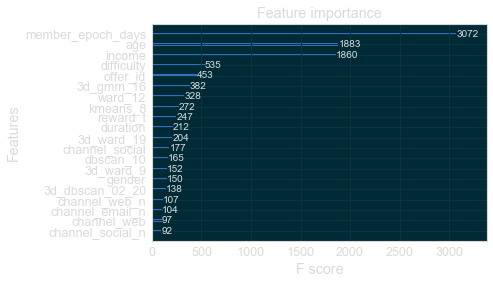

In [9]:
plot_importance(model.views_model.named_steps['estimator'], max_num_features=n_feats)

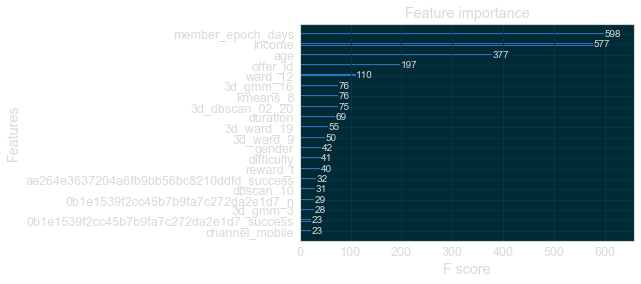

In [10]:
plot_importance(model.profits_model.named_steps['estimator'], max_num_features=n_feats)

In [21]:
# TODO: Evaluate the internal predictors

In [22]:
predictions = model.predict(X_train)
vis_probas = predictions[:, 0]
profits_viewed = predictions[:, 1]

In [52]:
from sklearn.metrics import roc_curve, f1_score, confusion_matrix

In [33]:
th = 0.5

/Users/antelinvestigacionydesarrollo/anaconda3/envs/sbucks/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



The best threshold is 0.5555555555555556, and gives a training F1-score of: 0.9133426431382505


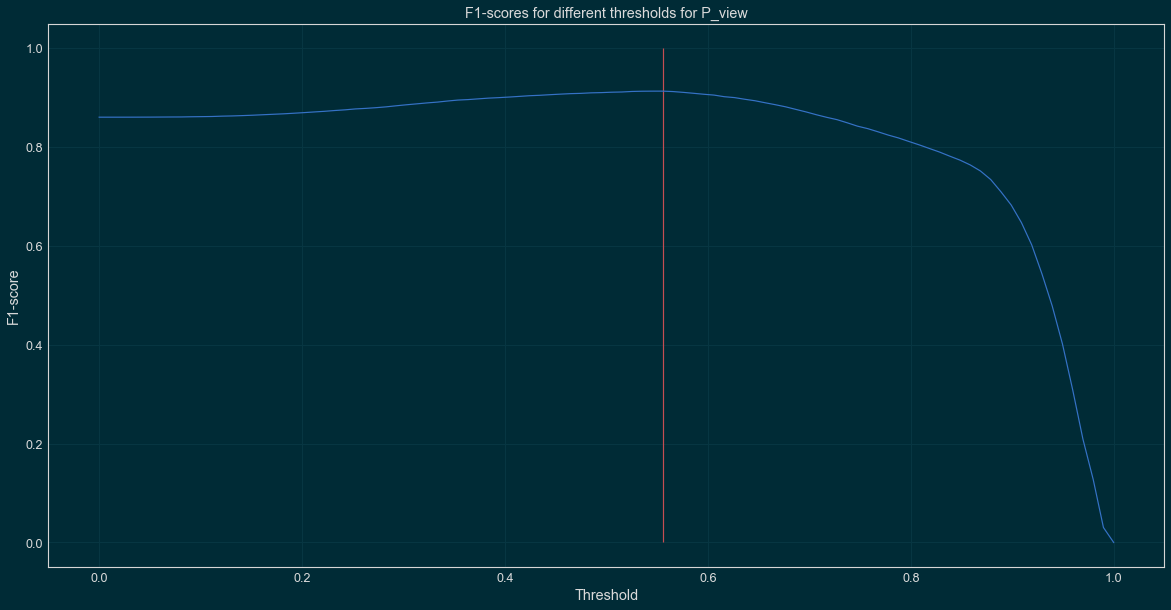

In [63]:
thresholds = np.linspace(0, 1, 100)
f1_scores = list()
for th in thresholds:
    vis_pred = (vis_probas > th).astype(int)
    f1_scores.append(f1_score(y_train['viewed'], vis_pred))

plt.plot(thresholds, f1_scores)
plt.title('F1-scores for different thresholds for P_view')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
best_th = thresholds[np.argmax(f1_scores)]
plt.vlines(best_th, 0, 1, colors='r')

print('The best threshold is {}, and gives a training F1-score of: {}'.format(best_th, 
                                                                      np.max(f1_scores)))

(3920, 2274, 1139, 17986)

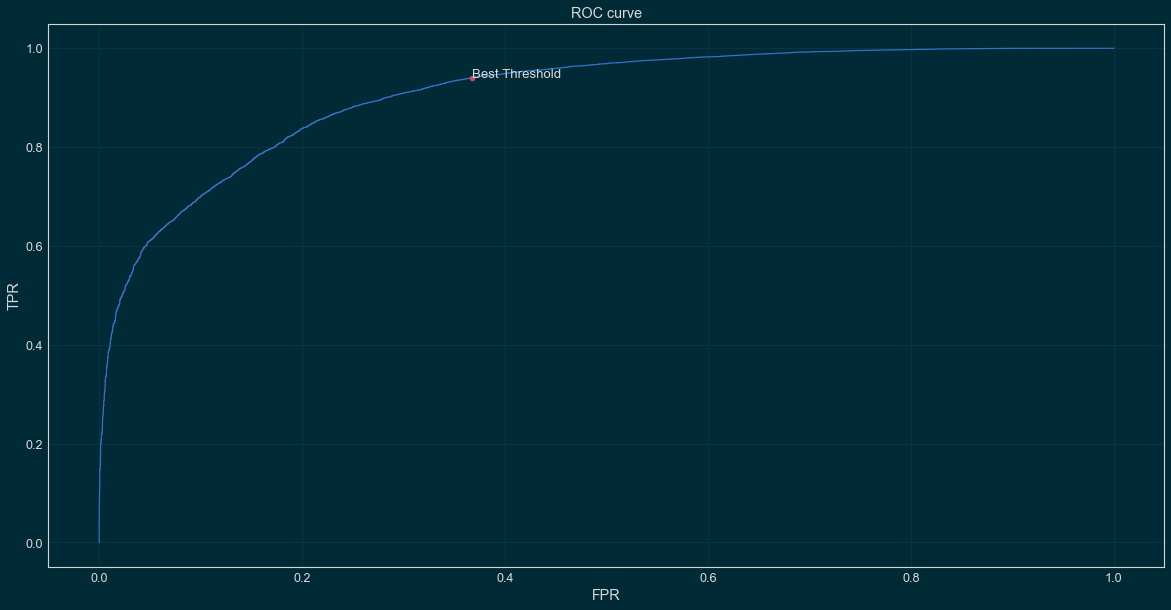

In [62]:
fpr, tpr, thresholds = roc_curve(y_train['viewed'].values, vis_probas)
plt.plot(fpr, tpr)
plt.title('ROC curve for the views')
plt.xlabel('FPR')
plt.ylabel('TPR')

vis_pred = (vis_probas > best_th).astype(int)
tn_s, fp_s, fn_s, tp_s = confusion_matrix(y_train['viewed'], vis_pred).ravel()
plt.plot(fp_s / (fp_s + tn_s), tp_s / (fn_s + tp_s), 'or')
plt.text(fp_s / (fp_s + tn_s), tp_s / (fn_s + tp_s), 'Best Threshold')
(tn_s, fp_s, fn_s, tp_s)

In [69]:
print('Training error (RMSE) when you know that the offers were viewed = {}'.format(
    np.sqrt(mse(y_train['profit_10_days'], profits_viewed))))

Training error (RMSE) when you know that the offers were viewed = 49.67315288972428


In [11]:
y_train_pred = model.predict_final_profits(X_train, null_offer)
print('Training error (RMSE) = {}'.format(np.sqrt(mse(y_train['profit_10_days'], y_train_pred))))

Training error (RMSE) = 49.89541725782038


## 5. Test Results (only run this once, after adjusting all the hyperparameters) <a id='test'/>
[Top](#top)

In [74]:
predictions = model.predict(X_test)
vis_probas = predictions[:, 0]
profits_viewed = predictions[:, 1]

# Evaluation of the views predictor
vis_pred = (vis_probas > 0.5).astype(int)
print('The F1-score for the views predictor in the test set is {}.'.format(
    f1_score(y_test['viewed'], vis_pred)))

The F1-score for the views predictor in the test set is 0.8472380198803224.


In [75]:
# Evaluation of the profits predictor
print('Test error (RMSE) when you know that the offers were viewed = {}'.format(
    np.sqrt(mse(y_test['profit_10_days'], profits_viewed))))

Test error (RMSE) when you know that the offers were viewed = 65.59105436189348


In [12]:
y_test_pred = model.predict_final_profits(X_test, null_offer)
print('Test error (RMSE) = {}'.format(np.sqrt(mse(y_test['profit_10_days'], y_test_pred))))

Test error (RMSE) = 65.75328180826874


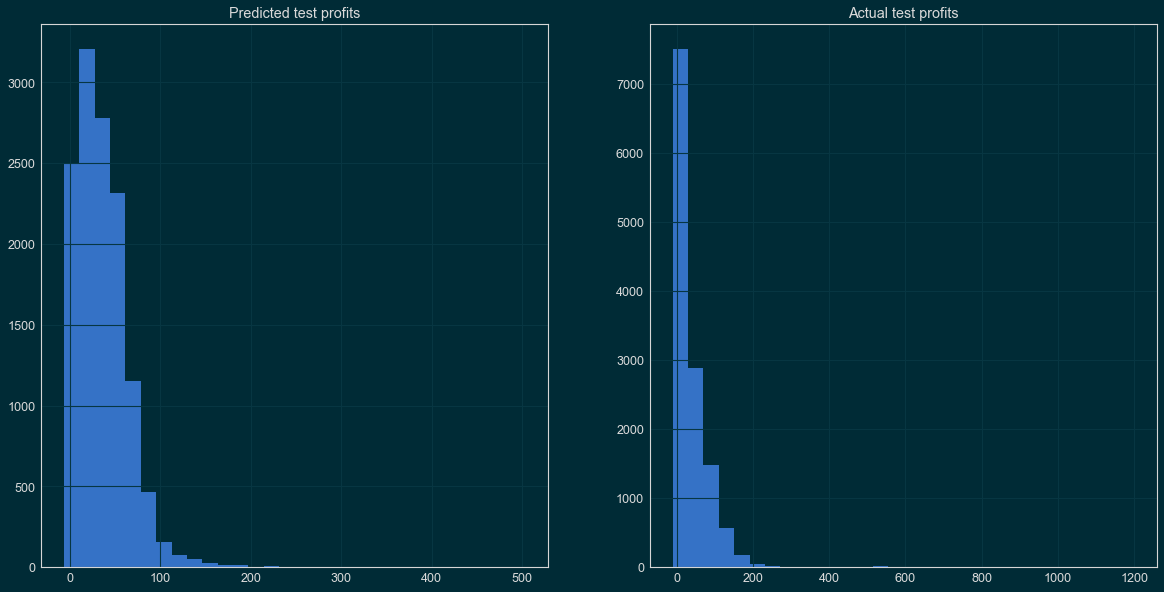

In [76]:
n_bins = 30
plt.subplot(1,2,1)
_ = plt.hist(y_test_pred, bins=n_bins)
plt.title('Predicted test profits')
plt.subplot(1,2,2)
y_test['profit_10_days'].hist(bins=n_bins)
_ = plt.title('Actual test profits')

/Users/antelinvestigacionydesarrollo/anaconda3/envs/sbucks/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



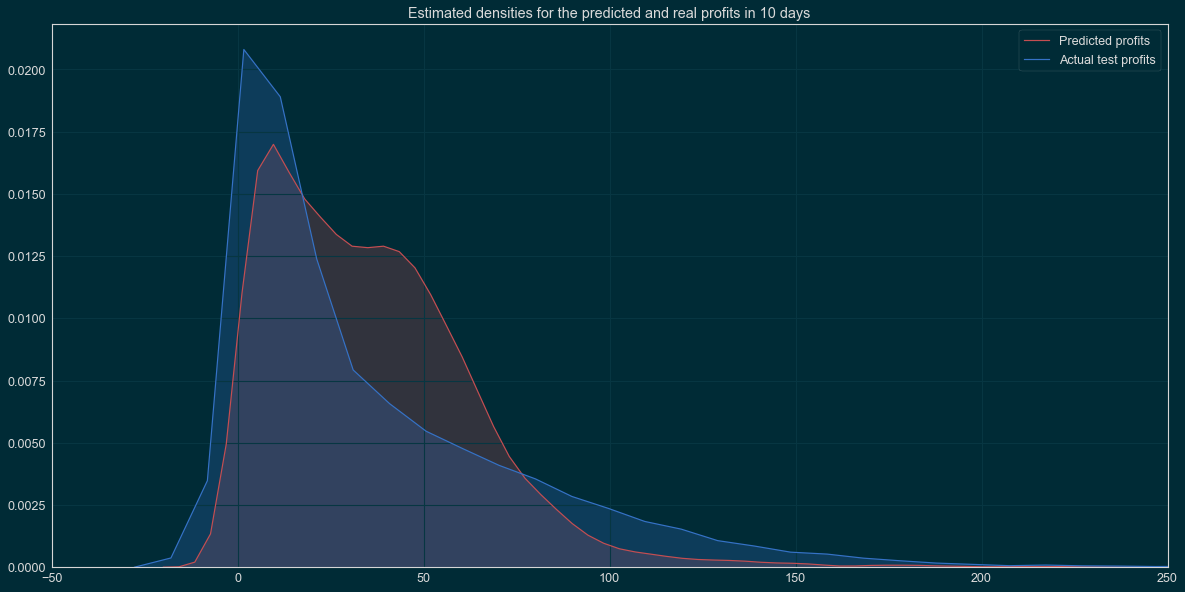

In [77]:
_ = sns.kdeplot(y_test_pred, shade=True, color="r", label='Predicted profits')
_ = sns.kdeplot(y_test['profit_10_days'], shade=True, color="b", label='Actual test profits')
_ = plt.xlim((-50, 250))
_ = plt.title('Estimated densities for the predicted and real profits in 10 days')

### Pseudo AB test

Ideally, to further test the model, it would be a good idea to perform an AB test. In a perfect situation we would be able to collect data from reality. In a less idealized world we would have access to a simlator, to which we can input offers. In the actual case, the only thing available is data from a simulator that was generated in the past, without any possibility of generating new data with our desired specifications. In any case, it is possible to perform what I call a "pseudo AB test".

The idea is to predict which are the best offers for each customer, then look for cases in the test set where, by chance, exactly those offers were sent. That will be the sample "with the new predictor". A random sample from the test set (of the same size as the one obtained before), will be the sample "without the predictor" (the samples may overlap, but that is not important; the important thing is that the second sample comes from the "old offer-sending procedure" distribution).

That method is far less than ideal. In particular the sample size is determined by chance and cannot be controlled. Despite that, its significance can be assessed.

In [78]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time _, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

portfolio

Basic preprocessing
CPU times: user 2.59 s, sys: 217 ms, total: 2.81 s
Wall time: 1.86 s


,difficulty,duration,id,offer_type,reward,channel_mobile,channel_social,channel_web,channel_email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [79]:
%time selected_offers, predicted_full = p10.choose_offer(model, X_test, portfolio)
selected_offers.head()

CPU times: user 29.6 s, sys: 2.75 s, total: 32.4 s
Wall time: 18.8 s


0    ae264e3637204a6fb9bb56bc8210ddfd
1    fafdcd668e3743c1bb461111dcafc2a4
2    fafdcd668e3743c1bb461111dcafc2a4
3    fafdcd668e3743c1bb461111dcafc2a4
4    ae264e3637204a6fb9bb56bc8210ddfd
dtype: object

In [80]:
num_samples = (X_test.offer_id == selected_offers.values).sum()
print('The old procedure sent the model\'s preferred offer in {0:.1f}% of the cases'.format(
    100*(X_test.offer_id == selected_offers.values).mean()))
print('There are {} samples of the selected offers of the new model.'.format(num_samples))

# Old model
np.random.seed(2018)
old_res = y_test.loc[np.random.choice(y_test.index, num_samples, replace=False), :]
old_views = old_res['viewed']
old_profits = old_res['profit_10_days']
print('\n' + '-'*100)
print('Total views for the old model: {} ({}%)'.format(old_views.sum(), 100*old_views.sum()/num_samples))
print('Total profit for the old model: {}'.format(old_profits.sum()))
print('Mean and std for the old model: mean = {}, std = {}'.format(old_profits.mean(), old_profits.std()))

# New model
new_res = y_test[(X_test.offer_id == selected_offers.values)]
new_views = new_res['viewed']
new_profits = new_res['profit_10_days']
print('-'*100)
print('Total views for the new model: {} ({}%)'.format(new_views.sum(), 100*new_views.sum()/num_samples))
print('Total profit for the new model: {}'.format(new_profits.sum()))
print('Mean and std for the new model: mean = {}, std = {}'.format(new_profits.mean(), new_profits.std()))
print('-'*100)



The old procedure sent the model's preferred offer in 8.7% of the cases
There are 1106 samples of the selected offers of the new model.

----------------------------------------------------------------------------------------------------
Total views for the old model: 821 (74.23146473779386%)
Total profit for the old model: 46464.03
Mean and std for the old model: mean = 42.01087703435803, std = 62.12693227344922
----------------------------------------------------------------------------------------------------
Total views for the new model: 1076 (97.2875226039783%)
Total profit for the new model: 53381.71000000001
Mean and std for the new model: mean = 48.265560578661855, std = 90.05228336013055
----------------------------------------------------------------------------------------------------


### Let's check the significance of the test

In [81]:
import scipy.stats as stats

In [82]:
pooled_profits = np.hstack([old_profits.values, new_profits.values])
mu_pooled = pooled_profits.mean()
sigma_pooled = pooled_profits.std()
mu_old = old_profits.mean()
mu_new = new_profits.mean()

z = (mu_new - mu_old) / sigma_pooled

print('z = {}'.format(z))
print('The p-value is: {}'.format(1 - stats.norm.cdf(z)))

z = 0.08082204847522771
The p-value is: 0.4677917366408061


So, at a significance level of 0.05, it is not possible to reject the null hypothesis. Anyway, that may only mean that we don't have enough data to decide. A properly designed experiment, with access to simulated or real data collecting, could reject the null hypothesis (one experiment, no more than that [to avoid the mistake of "trying until a good sample comes"], designed with the desired levels of significance and statistical power from the begining).

/Users/antelinvestigacionydesarrollo/anaconda3/envs/sbucks/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



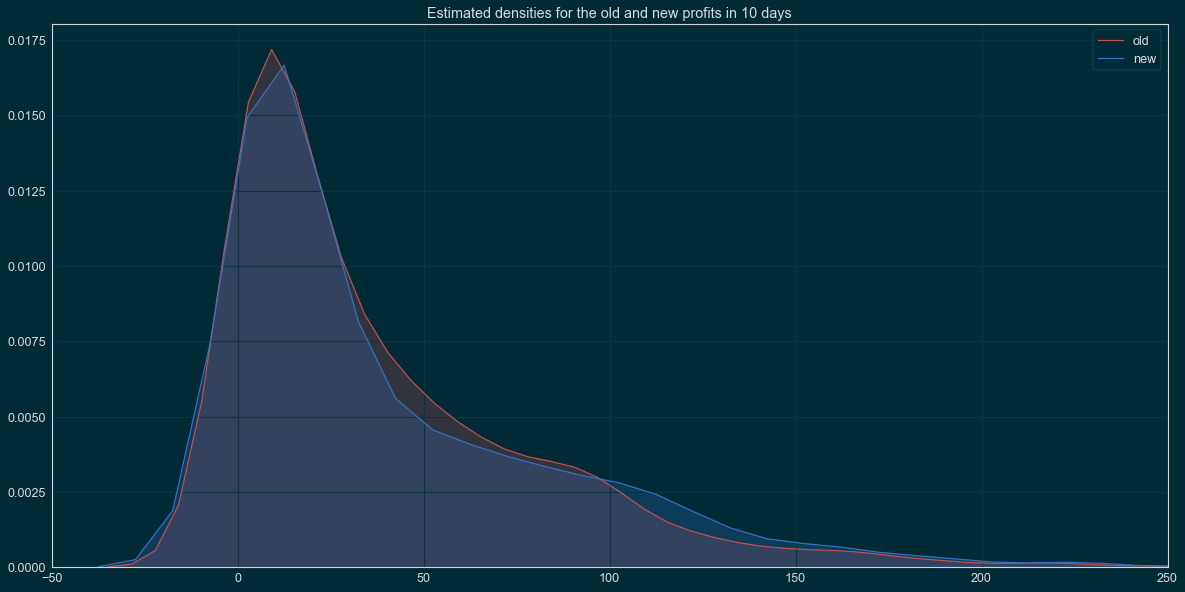

In [83]:
import seaborn as sns
 
_ = sns.kdeplot(old_profits, shade=True, color="r", label='old')
_ = sns.kdeplot(new_profits, shade=True, color="b", label='new')
_ = plt.xlim((-50, 250))
_ = plt.title('Estimated densities for the old and new profits in 10 days')